<a href="https://colab.research.google.com/github/AngeMervaneJdev/ML_AI_1/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#init

In [2]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from gensim.models import Word2Vec

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/nlp'

In [ ]:

! pwd

#Download IMDB to the current folder
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip
!tar zxf aclImdb_v1.tar.gz
# aclImdb / train / unsup is unlabeled and removed
!rm -rf aclImdb/train/unsup
# Show IMDB dataset description
!cat aclImdb/README

/content
--2022-04-30 20:19:55--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  56.5MB/s    in 1.4s    

2022-04-30 20:19:56 (56.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also inc

In [6]:
os.chdir(file_path)

In [7]:
from sklearn.datasets import load_files
train_review = load_files(os.path.join(file_path, 'aclImdb/train/'), encoding='utf-8')
x_train_dataset, y_train_dataset = train_review.data, train_review.target
#test_review = load_files(os.path.join(src_path, 'aclImdb/test/'), encoding='utf-8')
#x_test, y_test = test_review.data, test_review.target
# Display of the correspondence between 0, 1 of the label and the meaning
print(train_review.target_names)

['neg', 'pos']


#Exemple

In [32]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

  
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
display(bow)
#Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

array([[0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 0],
       [0, 2, 0, 0, 0, 0, 0, 3]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [33]:
#Specify the range of n-gram used in # ngram_range
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


#[Problem 1] Scratch implementation of BoW

In [17]:
def bow(sentences, n_gram):
    if (type(sentences) is not list):
        raise Exception("sentences is not list") 
    
    if (type(n_gram) is not int):
        raise Exception("n_grams is not int") 

    feature_names = []
    cnt_array = np.empty((len(sentences), 0))

    for sentence_idx, sentence in enumerate(sentences):
        sentence = sentence.lower().replace('?', '')
        sentence = sentence.lower().replace('!', '').split(' ')


        for i in range(0, len(sentence) - n_gram + 1):
            feature = ' '.join(sentence[i:i + n_gram])
            if (feature not in feature_names):
                feature_names.append(feature)
                cnt_array = np.append(cnt_array, np.zeros((len(sentences), 1)), axis=1)
            cnt_array[sentence_idx, feature_names.index(feature)] += 1
    
    return feature_names, cnt_array.astype(np.int)

In [35]:
sentences = [
             'This movie is SOOOO funny!!!',
             'What a movie! I never',
             'best movie ever!!!!! this movie'
        ]

In [36]:
feature_names, cnt_array = bow(sentences, 1)
df = pd.DataFrame(cnt_array, columns=feature_names)
display(df)

feature_names, cnt_array = bow(sentences, 2)
df = pd.DataFrame(cnt_array, columns=feature_names)
display(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,1,0,0,0,0,0,0,0,1,1,1


In [37]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(sentences)).toarray()
#Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(sentences)).toarray()
#Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,1,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1,0


#[Problem 2] TF-IDF calculation

In [38]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


In [10]:
# Download Stopword for the first time
stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ..
print("length: {}".format(len(stop_words)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all'

In [40]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


#Vectorize the IMDB movie review dataset with TF-IDF

In [41]:
MAX_FEATURES = 5000

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1,1),
    norm='l2',
    stop_words=stop_words,
    max_features=MAX_FEATURES
)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_dataset).toarray()

print(tfidf_vectorizer.get_feature_names_out())
print(x_train_tfidf[:100])
print(x_train_tfidf.shape)

['0' '00' '000' ... 'zombie' 'zombies' 'zone']
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.14273931 0.         0.         ... 0.         0.         0.        ]]
(25000, 5000)


#[Problem 3] Learning using TF-IDF

In [13]:
def compute_score(y_pred, y):
    print("Accuracy: {}".format(metrics.accuracy_score(y_pred=y_pred, y_true=y)))
    print("Precision: {}".format(metrics.precision_score(y_pred=y_pred, y_true=y)))
    print("Recall: {}".format(metrics.recall_score(y_pred=y_pred, y_true=y)))
    print("F1: {}".format(metrics.f1_score(y_pred=y_pred, y_true=y)))



In [43]:
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, y_train_dataset, test_size=0.25, random_state=5)
model = LogisticRegression(max_iter=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
compute_score(y_pred, y_test)

Accuracy: 0.88848
Precision: 0.8738433066008636
Recall: 0.9077218840115348
F1: 0.8904604746188904


In [44]:
MAX_FEATURES = 5000

tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(3,3),
    norm='l2',
    stop_words=stop_words,
    max_features=MAX_FEATURES
)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_dataset).toarray()

print(tfidf_vectorizer.get_feature_names_out())
print(x_train_tfidf[:10])
print(x_train_tfidf.shape)

['1 000 000' '1 1 2' '1 10 I' ... 'yet br br' 'young boy named'
 'zombies br br']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(25000, 5000)


In [46]:

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_dataset).toarray()
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, y_train_dataset)
model = LogisticRegression(max_iter=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
compute_score(y_pred, y_test)

Accuracy: 0.72096
Precision: 0.7062391681109186
Recall: 0.7708070617906684
F1: 0.7371118480554718


In [47]:
x_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.32183651, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
MAX_FEATURES = 10000

tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(3,3),
    norm='l2',
    stop_words=stop_words,
    max_features=MAX_FEATURES
)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_dataset).toarray()

print(tfidf_vectorizer.get_feature_names_out())
print(x_train_tfidf[:10])
print(x_train_tfidf.shape)

['000 year old' '1 000 000' '1 1 2' ... 'young woman named' 'youth br br'
 'zombies br br']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(25000, 10000)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, y_train_dataset, test_size=0.25, random_state=5)

model = LogisticRegression(max_iter=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
compute_score(y_pred, y_test)

Accuracy: 0.7304
Precision: 0.7111764705882353
Recall: 0.774751682153156
F1: 0.7416040484588252


#[Problem 4] Scratch mounting of TF-IDF

In [15]:
def tfidf_std(sentences, n_gram):
    feature_names, cnt_array = bow(sentences, n_gram)

    tfidf_array = np.zeros(cnt_array.shape).astype(np.float64)
    for d_idx, d in enumerate(cnt_array):
        for t_idx, t_cnt in enumerate(d):
            tf = (t_cnt / np.sum(d)).astype(np.float64)
            idf = np.log(cnt_array.shape[0] / np.count_nonzero(cnt_array[:, t_idx])).astype(np.float64)
            tfidf_array[d_idx, t_idx] = tf * idf
    
    return feature_names, tfidf_array

def tfidf_sklearn(sentences, n_gram):
    feature_names, cnt_array = bow(sentences, n_gram)

    tfidf_array = np.zeros(cnt_array.shape).astype(np.float64)
    for d_idx, d in enumerate(cnt_array):
        for t_idx, t_cnt in enumerate(d):
            tf = t_cnt.astype(np.float64)
            idf = (np.log((1 + cnt_array.shape[0]) / (1 + np.count_nonzero(cnt_array[:, t_idx]))) + 1).astype(np.float64)
            tfidf_array[d_idx, t_idx] = tf * idf
    
    return feature_names, tfidf_array

sentences = [
             'This movie is SOOOO funny!!!',
             'What a movie! I never',
             'best movie ever!!!!! this movie'
        ]

In [18]:
feature_names_std, tfidf_array_std = tfidf_std(sentences, 1)

print("feature_names shape: {}\n{}".format(len(feature_names_std), feature_names_std))
print("\n\ntfidf shape: {}\n{}".format(tfidf_array_std.shape, tfidf_array_std))

feature_names shape: 11
['this', 'movie', 'is', 'soooo', 'funny', 'what', 'a', 'i', 'never', 'best', 'ever']


tfidf shape: (3, 11)
[[0.08109302 0.         0.21972246 0.21972246 0.21972246 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.21972246
  0.21972246 0.21972246 0.21972246 0.         0.        ]
 [0.08109302 0.         0.         0.         0.         0.
  0.         0.         0.         0.21972246 0.21972246]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [19]:
feature_names_sklearn, tfidf_array_sklearn = tfidf_sklearn(sentences, 1)

print("feature_names shape: {}\n{}".format(len(feature_names_sklearn), feature_names_sklearn))
print("\n\ntfidf shape: {}\n{}".format(tfidf_array_sklearn.shape, tfidf_array_sklearn))

feature_names shape: 11
['this', 'movie', 'is', 'soooo', 'funny', 'what', 'a', 'i', 'never', 'best', 'ever']


tfidf shape: (3, 11)
[[1.28768207 1.         1.69314718 1.69314718 1.69314718 0.
  0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         1.69314718
  1.69314718 1.69314718 1.69314718 0.         0.        ]
 [1.28768207 2.         0.         0.         0.         0.
  0.         0.         0.         1.69314718 1.69314718]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#verify with sklearn instance

In [20]:

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1,1),
    norm=None,
)

tfidf_array = tfidf_vectorizer.fit_transform(sentences).toarray()

print("feature_names shape: {}\n{}".format(len(tfidf_vectorizer.get_feature_names_out()), tfidf_vectorizer.get_feature_names_out()))
print("\n\ntfidf shape: {}\n{}".format(tfidf_array.shape, tfidf_array))

feature_names shape: 11
['a' 'best' 'ever' 'funny' 'i' 'is' 'movie' 'never' 'soooo' 'this' 'what']


tfidf shape: (3, 11)
[[0.         0.         0.         1.69314718 0.         1.69314718
  1.         0.         1.69314718 1.28768207 0.        ]
 [1.69314718 0.         0.         0.         1.69314718 0.
  1.         1.69314718 0.         0.         1.69314718]
 [0.         1.69314718 1.69314718 0.         0.         0.
  2.         0.         0.         1.28768207 0.        ]]


#[Problem 5] Corpus pretreatment


In [21]:

sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]

model = Word2Vec(min_count=1, size=10) # Set the number of dimensions to 10
model.build_vocab(sentences) # Preparation
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) #Learning

print("List of vocabulary : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("Vector of {}: \n{}".format(vocab, model.wv[vocab]))

List of vocabulary : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
Vector of this: 
[-0.01347666  0.0050008   0.02957232 -0.00539697  0.02435464  0.00388379
 -0.02624959 -0.04663858 -0.01846152 -0.01003237]
Vector of movie: 
[ 0.03106944 -0.03743075 -0.00930947  0.04433664  0.0219944   0.03109553
 -0.02432941 -0.02523755 -0.00521598 -0.03714861]
Vector of is: 
[-0.002535   -0.04605755 -0.03684922 -0.01195191  0.0280169   0.00033027
 -0.01375774 -0.02186151  0.01085878 -0.04691723]
Vector of very: 
[-0.01852046  0.00948793 -0.0318515  -0.04849023  0.0097593  -0.04500052
 -0.02882147  0.01935661 -0.04855201  0.03498722]
Vector of good: 
[-0.005413   -0.0453669   0.00505311 -0.03496052  0.0312732   0.02033271
 -0.0430923   0.01770617 -0.0230167   0.01816355]
Vector of film: 
[-0.04690125 -0.00322681  0.01118846  0.00578103  0.02243708 -0.02643311
  0.0270808   0.00195273  0.00953713 -0.02027034]
Vector of a: 
[-0.00031132  0.00187549 -0.01842847 -0.00533717  0.023

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


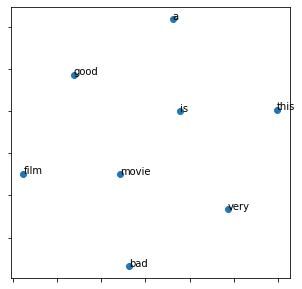

In [22]:
model.wv.most_similar(positive="good", topn=3)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

#Problem 6] Learning Word2Vec

In [24]:
def word_tokenizer(dataset):
    return [re.findall(r'\b\w+\b', str(corpus).lower()) for corpus in dataset]

x_train_tokens = word_tokenizer(x_train)

In [25]:
model = Word2Vec(min_count=1, size=10)
model.build_vocab(x_train_tokens)
model.train(x_train_tokens, total_examples=model.corpus_count, epochs=model.iter)

print("List of vocabulary : {}".format(len(model.wv.vocab.keys())))

List of vocabulary : 52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until
